In [2]:
import os
import numpy as np
import typing
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import pathlib

In [9]:
path_to_file = pathlib.Path('./data/fra-eng/fra.txt')
path_to_file

WindowsPath('data/fra-eng/fra.txt')

In [27]:
def load_data(path):
    text = path.read_text(encoding='utf-8')
    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]
    pairs = [pair[:2] for pair in pairs]
    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

targ, inp = load_data(path_to_file)
print(inp[:1])
print(targ[:1])

['Va !']
['Go.']


### CREER UN ENSEMBLE DE DONNEES
CHAINES BATTAGES ET LOTS

In [28]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [29]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b"Qu'est-ce que tu as r\xc3\xa9pondu\xe2\x80\xaf?"
 b'Ils sont tous terrifi\xc3\xa9s.'
 b"Je savais que \xc3\xa7a t'int\xc3\xa9resserait."
 b"Elle a pleur\xc3\xa9 lorsqu'elle a entendu l'histoire."
 b'Tom insista pour y aller seul.'], shape=(5,), dtype=string)

tf.Tensor(
[b'What did you answer?' b"They're all terrified."
 b'I knew that would interest you.' b'She cried when she heard the story.'
 b'Tom insisted on going alone.'], shape=(5,), dtype=string)


### TEXT PREPROCESSING
NORMALISATION UNICODE

In [39]:
example_text = tf.constant("J\'étais là!")
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b"J'\xc3\xa9tais l\xc3\xa0!"
b"J'e\xcc\x81tais la\xcc\x80!"


In [43]:
def tf_lower_and_split_punct(text):
    # Split accented characters
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation
    text = tf.strings.regex_replace(text, '[^ a-z.?!,\']', '')
    # Add spaces around punctuation
    text = tf.strings.regex_replace(text, '[.?!,\']', r' \0 ')
    # Strip whitespace
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [44]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

J'étais là!
[START] j ' etais la ! [END]


VECTORISATION DU TEXTE

In [45]:
max_vocab_size = 5000
input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

In [46]:
input_text_processor.adapt(inp)
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', "'", 'je', 'a', 'de', '?']

In [47]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)
output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', "'", 'i', 'you', 'to', 'the']

In [48]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   36,    5,   61,   11,   25,   91, 1087,    9,    3],
       [   2,   70,   63,   99,    1,    4,    3,    0,    0,    0],
       [   2,    6,  266,   11,   39,   73,    5, 4865,    4,    3]],
      dtype=int64)>

CONVERTIR LES ID DE JETON EN TEXTE

In [49]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

"[START] qu ' estce que tu as repondu ? [END]             "

TRANSFORMER ID DE JETON EN MASQUE

Text(0.5, 1.0, 'Mask')

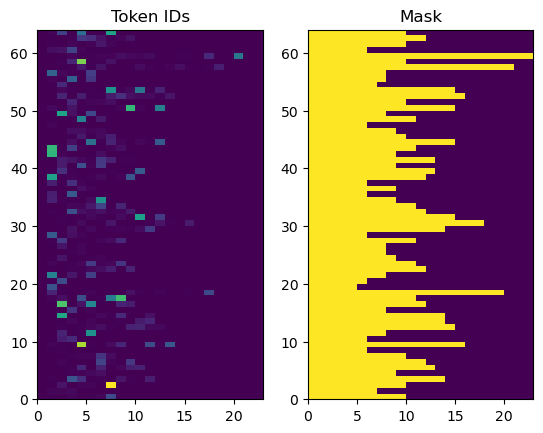

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

### MODEL ENCODEUR/DECODEUR

In [53]:
embedding_dim = 256
units = 1024

CLASS DE VERIFICATION DE FORME ()

In [62]:
class ShapeChecker():
    def __init__(self):
        self.shapes = {}
    
    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return
        if isinstance(names, str):
            names = (names,)
        shape = tf.shape(tensor)
        rank = tf.rank(tensor)
        if rank != len(names):
            raise ValueError(
                f'Rank mismatch:\n'
                f'    found {rank}: {shape.numpy()}\n'
                f'    expected {len(names)}: {names}\n'
            )
        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]
            if (broadcast and new_dim==1):
                continue
            if old_dim is None:
                self.shapes[name] = new_dim
                continue
            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"     found: {new_dim}\n"
                                 f"     expected: {old_dim}\n")

ENCODEUR

In [65]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        # EMBEDDING LAYER (TOKENS TO VECTORS)
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)
        # RNN LAYER
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )
    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        # EMBEDDING
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        # GRU
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        return output, state

In [66]:
examples_tokens = input_text_processor(example_input_batch)
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)
print(f'Input batch, shape(batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape(batch, s): {examples_tokens.shape}')
print(f'Encoder output, shape(batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape(batch, units): {example_enc_state.shape}')

Input batch, shape(batch): (64,)
Input batch tokens, shape(batch, s): (64, 23)
Encoder output, shape(batch, s, units): (64, 23, 1024)
Encoder state, shape(batch, units): (64, 1024)


TETE D'ATTENTION

In [71]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()
        
    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask = [query_mask, value_mask],
            return_attention_scores = True
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        return context_vector, attention_weights

In [72]:
attention_layer = BahdanauAttention(units)
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)
print(f'Attention result shape (bs, query_seq_len, units): {context_vector.shape}')
print(f'Attention weights shape (bs, qsl, vsl) {attention_weights.shape}')

Attention result shape (bs, query_seq_len, units): (64, 2, 1024)
Attention weights shape (bs, qsl, vsl) (64, 2, 23)


Les poids d'attention doit correspondre exactement a 1.0 pour chaque sequence

Text(0.5, 1.0, 'Mask')

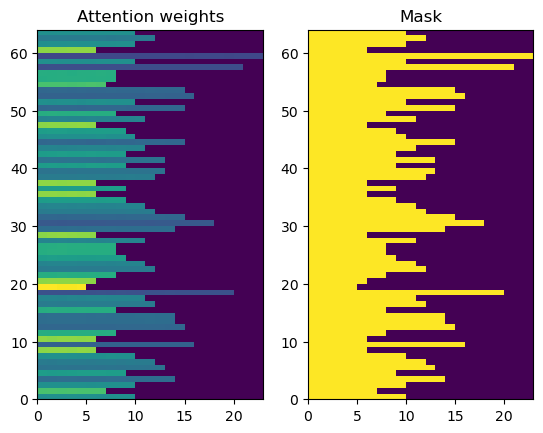

In [74]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')
plt.subplot(1, 2, 2)
plt.pcolormesh(examples_tokens != 0)
plt.title('Mask')

DECODEUR

In [76]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any
    
class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        # 1 TOKEN IDs TO VECTOR
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, embedding_dim)
        # 2 RNN pour garder une trace de ce qu'il a genere jusqu'a present
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
        )
        # 3 RNN comme requete a l'attention sur la sortie
        self.attention = BahdanauAttention(self.dec_units)
        # 4 generate a attention vector
        self.Wc = tf.keras.layers.Dense(
            dec_units,
            activation=tf.math.tanh,
            use_bias=False
        )
        # 5 Generate logits predictions with attention vector
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)
        
    def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        shape_checker = ShapeChecker()
        shape_checker(inputs.new_tokens, ('batch', 't'))
        shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
        shape_checker(inputs.mask, ('batch', 's'))
        if state is not None:
            shape_checker(state, ('batch', 'dec_units'))
        # 1 Look up the embeddings
        vectors = self.embedding(inputs.new_tokens)
        shape_checker(vectors, ('batch', 't', 'embedding_dim'))
        # 2 Process one step with the RNN
        rnn_output, state = self.gru(vectors, initial_state=state)
        shape_checker(rnn_output, ('batch', 't', 'dec_units'))
        shape_checker(state, ('batch', 'dec_units'))
        # 3 Use the RNN output as the query for the attention over the encoder output
        context_vector, attention_weights = self.attention(
            query=rnn_output,
            value=inputs.enc_output,
            mask=inputs.mask
        )
        shape_checker(context_vector, ('batch', 't', 'dec_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        # 4 Join the context_vector and rnn_output
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        attention_vector = self.Wc(context_and_rnn_output)
        shape_checker(attention_vector, ('batch', 't', 'dec_units'))
        # 5 Generate logit predicitons
        logits = self.fc(attention_vector)
        shape_checker(logits, ('batch', 't', 'output_vocab_size'))
        return DecoderOutput(logits, attention_weights), state

In [77]:
decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

CONVERT THE TARGET SEQUENCE AND COLLECT THE '[START]' TOKENS

In [78]:
example_output_tokens = output_text_processor(example_target_batch)
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

RUN THE DECODER

In [79]:
dec_result, dec_state = decoder(
    inputs= DecoderInput(
        new_tokens=first_token,
        enc_output=example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=example_enc_state
)
print(f'Logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'State shape: (batch_size, dec_units) {dec_state.shape}')

Logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
State shape: (batch_size, dec_units) (64, 1024)


Exemple de jeton en fonction des logits

In [80]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decoder le jeton comme premier mot de la sortie

In [81]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['halfway'],
       ['unfortunately'],
       ['snacks'],
       ['refer'],
       ['unimpressed']], dtype='<U16')

Use decoder for generating a second logits

In [82]:
dec_result, dec_state = decoder(
    DecoderInput(
        sampled_token,
        example_enc_output,
        mask=(example_tokens != 0)
    ),
    state=dec_state
)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['sock'],
       ['well'],
       ['bother'],
       ['compete'],
       ['meters']], dtype='<U16')

### TRAINING
LOSS FUNCTION

In [83]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,
            reduction='none'
        )
        
    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        # Calculate the loss for each item in the batch
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))
        # Mask off the losses on padding
        mask = tf.cast(y_true !=0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask
        return tf.reduce_sum(loss)

METTRE EN OEUVRE L'ETAPE DE FORMATION

In [94]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units, input_text_processor, output_text_processor, use_tf_function=True):
        super().__init__()
        encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()
    
    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)
    def _preprocess(self, input_text, target_text):
        self.shape_checker(input_text, ('batch',))
        self.shape_checker(target_text, ('batch',))
        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        self.shape_checker(input_tokens, ('batch', 's'))
        self.shape_checker(target_tokens, ('batch', 't'))
        # Convert IDs to masks
        input_mask = input_tokens != 0
        self.shape_checker(input_mask, ('batch', 's'))
        target_mask = target_tokens != 0
        self.shape_checker(target_mask, ('batch', 't'))
        return input_tokens, input_mask, target_tokens, target_mask
    
    def _train_step(self, inputs):
        input_text, target_text = inputs
        (input_tokens, input_mask, target_tokens, target_mask) = self._preprocess(input_text, target_text)
        max_target_length = tf.shape(target_tokens)[1]
        with tf.GradientTape() as tape:
            enc_output, enc_state = self.encoder(input_tokens)
            self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
            self.shape_checker(enc_state, ('batch', 'enc_units'))
            dec_state = enc_state
            loss = tf.constant(0.0)
            for t in  tf.range(max_target_length-1):
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask, enc_output, dec_state)
                loss = loss + step_loss
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return {'batch_loss': average_loss}
    
    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
        # Run decoder step
        decoder_input = DecoderInput(new_tokens=input_token, enc_output=enc_output, mask=input_mask)
        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
        self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
        self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        self.shape_checker(dec_state, ('batch', 'dec_units'))
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)
        return step_loss, dec_state

TESTER L'ETAPE DE FORMATION

In [95]:
translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False
)
# Configure loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

In [96]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [97]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6533213>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6236796>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5698886>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.420364>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.891374>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.927641>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.814975>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2321353>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0027847>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9783778>}
CPU times: total: 1min 18s
Wall time: 41.7 s


In [98]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]), tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [99]:
TrainTranslator._tf_train_step = _tf_train_step

In [100]:
translator.use_tf_function = True
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9819963>}

In [101]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9490888>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9024265>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8277218>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7534266>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7124224>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6922274>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6765287>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.65456>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6299243>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5963814>}

CPU times: total: 1min 40s
Wall time: 27.9 s


Le model peut suradapter un seul lot d'entrees

....................................................................................................


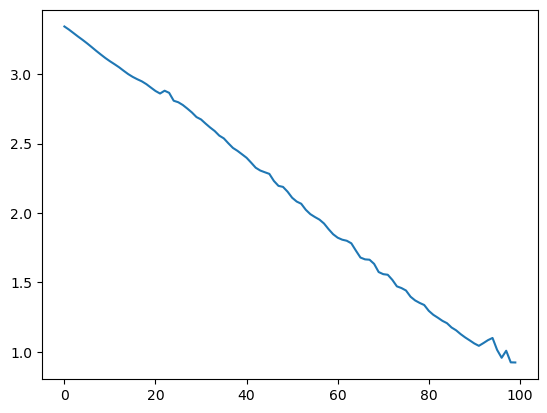

In [103]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())
print()
plt.plot(losses)

CREATE A COPIE OF MODEL FOR TRAINING FROM 0

In [107]:
train_translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss()
)

CALLBACK

In [108]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []
    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])
batch_loss = BatchLogs('batch_loss')

In [109]:
train_translator.fit(dataset, epochs=3, callbacks=[batch_loss])

Epoch 1/3
3086/3086 [==============================] - 8827s 3s/step - batch_loss: 1.5063
Epoch 2/3
3086/3086 [==============================] - 8621s 3s/step - batch_loss: 0.7864
Epoch 3/3
3086/3086 [==============================] - 8595s 3s/step - batch_loss: 0.6069


Text(0, 0.5, 'CE/toke')

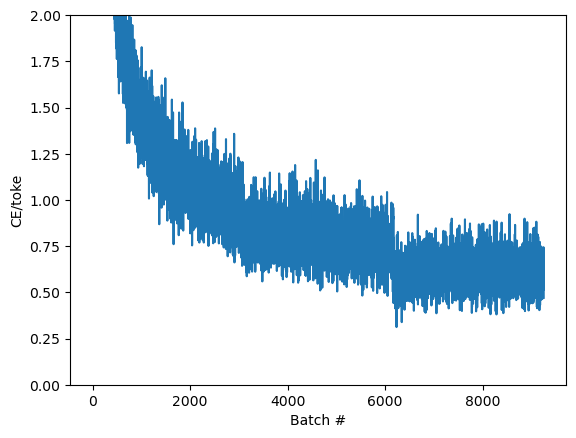

In [111]:
plt.plot(batch_loss.logs)
plt.ylim([0, 2])
plt.xlabel('Batch #')
plt.ylabel('CE/toke')

### TRANSLATE

In [114]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor, output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True
            )
        )
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token=''
        )
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask
        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

In [115]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor
)

C:\Users\RAKOTONDRAVAO\AppData\Local\Temp\ipykernel_10800\832058301.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


CONVERTIR LES IDENTIFIANTS DE JETON EN TEXTE

In [116]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))
    result_text = tf.strings.reduce_join(result_text_tokens, axis=1, separator=' ')
    shape_checker(result_text, ('batch'))
    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text

Translator.tokens_to_text = tokens_to_text

In [117]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2],
    minval=0,
    dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size()
)
translator.tokens_to_text(example_output_tokens).numpy()

array([b'musical popular', b'seafood doorbell', b'instead facts',
       b'strictly appeal', b'push for'], dtype=object)

ECHANTILLON DES PREDICTIONS DU DECODER

In [120]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)
    logits = tf.where(self.token_mask, -np.inf, logits)
    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature, num_samples=1)
    shape_checker(new_tokens, ('batch', 't'))
    return new_tokens

Translator.sample = sample

TEST SAMPLE ON RANDOM INPUT

In [121]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4187],
       [2511],
       [ 846],
       [2451],
       [2319]], dtype=int64)>

IMPLEMENT TRADUCTION BOUCLE

In [122]:
def translate_unrolled(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens!=0))
        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        attention.append(dec_result.attention_weights)
        new_tokens = self.sample(dec_result.logits, temperature)
        done = done | (new_tokens == self.end_token)
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        result_tokens.append(new_tokens)
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)
    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}
    
Translator.translate = translate_unrolled

EXECUTE TRANSLATE IN SIMPLE INPUT

In [123]:
%%time
input_text = tf.constant([
    'Il fait vraiment froid ici.',
    'C\'est ma vie.'
])
result = translator.translate(
    input_text = input_text
)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it ' s really cold there .
this is my life .

CPU times: total: 781 ms
Wall time: 630 ms


### SAVE MODEL
WRAP TRANSLATE IN tf.function

In [124]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)
Translator.tf_translate = tf_translate

COMPILE tf.function (EXECUTE ONE TIME)

In [125]:
%%time
result = translator.tf_translate(input_text = input_text)

CPU times: total: 46.2 s
Wall time: 35.3 s


In [127]:
%%time
result = translator.tf_translate(input_text=input_text)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it ' s really cold that .
those ' s my life .

CPU times: total: 875 ms
Wall time: 290 ms


### [*] UTILISER UNE BOUCLE SYMBOLIQUE

In [128]:
def translate_symbolic(self, input_text, *, max_length=50, return_attention=True, temperature=1.0):
    shape_checker = ShapeChecker()
    shape_checker(input_text, ('batch',))
    batch_size = tf.shape(input_text)[0]

    # Encode the input
    input_tokens = self.input_text_processor(input_text)
    shape_checker(input_tokens, ('batch', 's'))
    enc_output, enc_state = self.encoder(input_tokens)
    shape_checker(enc_output, ('batch', 's', 'enc_units'))
    shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    shape_checker(new_tokens, ('batch', 't1'))

    # Initialize the accumulators
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    shape_checker(done, ('batch', 't1'))

    for t in tf.range(max_length):
        dec_input = DecoderInput(
            new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

        dec_result, dec_state = self.decoder(dec_input, state=dec_state)

        shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
        attention = attention.write(t, dec_result.attention_weights)

        new_tokens = self.sample(dec_result.logits, temperature)
        shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
        shape_checker(new_tokens, ('batch', 't1'))

        # If a sequence produces an `end_token`, set it `done`
        done = done | (new_tokens == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

        # Collect the generated tokens
        result_tokens = result_tokens.write(t, new_tokens)

        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    result_tokens = result_tokens.stack()
    shape_checker(result_tokens, ('t', 'batch', 't0'))
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])
    shape_checker(result_tokens, ('batch', 't'))

    result_text = self.tokens_to_text(result_tokens)
    shape_checker(result_text, ('batch',))

    if return_attention:
        attention_stack = attention.stack()
        shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

        attention_stack = tf.squeeze(attention_stack, 2)
        shape_checker(attention_stack, ('t', 'batch', 's'))

        attention_stack = tf.transpose(attention_stack, [1, 0, 2])
        shape_checker(attention_stack, ('batch', 't', 's'))

        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}
    
Translator.translate = translate_symbolic

In [130]:
%%time
result = translator.translate(input_text=input_text)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it ' s really cold here .
this is my life .

CPU times: total: 734 ms
Wall time: 580 ms


In [131]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
    return self.translate(input_text)
Translator.tf_translate = tf_translate

In [132]:
%%time
result = translator.translate(input_text=input_text)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it ' s really cold around here .
this is my life .

CPU times: total: 859 ms
Wall time: 762 ms


### VISUALIZE THE PROCESSUS

In [133]:
a = result['attention'][0]
print(np.sum(a, axis=-1))

[1.         0.99999994 1.         1.         1.         1.
 1.0000001  0.9999999  1.        ]


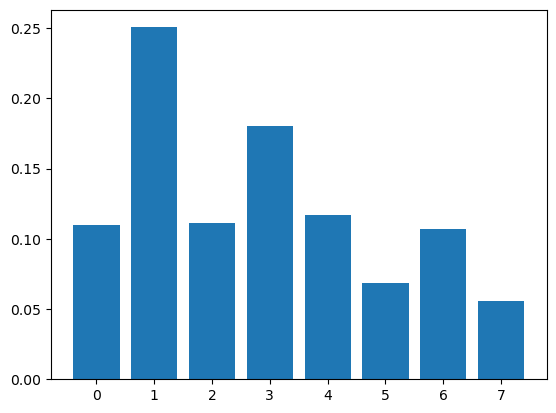

In [134]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

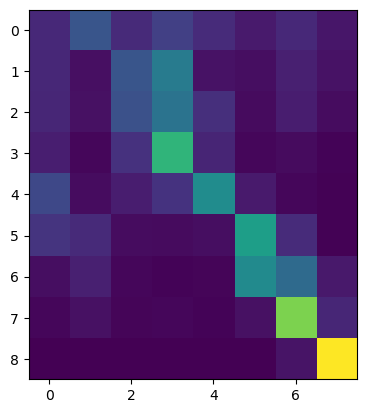

In [135]:
plt.imshow(np.array(a), vmin=0.0)

PLOT ATTENTION

In [136]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

C:\Users\RAKOTONDRAVAO\AppData\Local\Temp\ipykernel_10800\1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\RAKOTONDRAVAO\AppData\Local\Temp\ipykernel_10800\1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


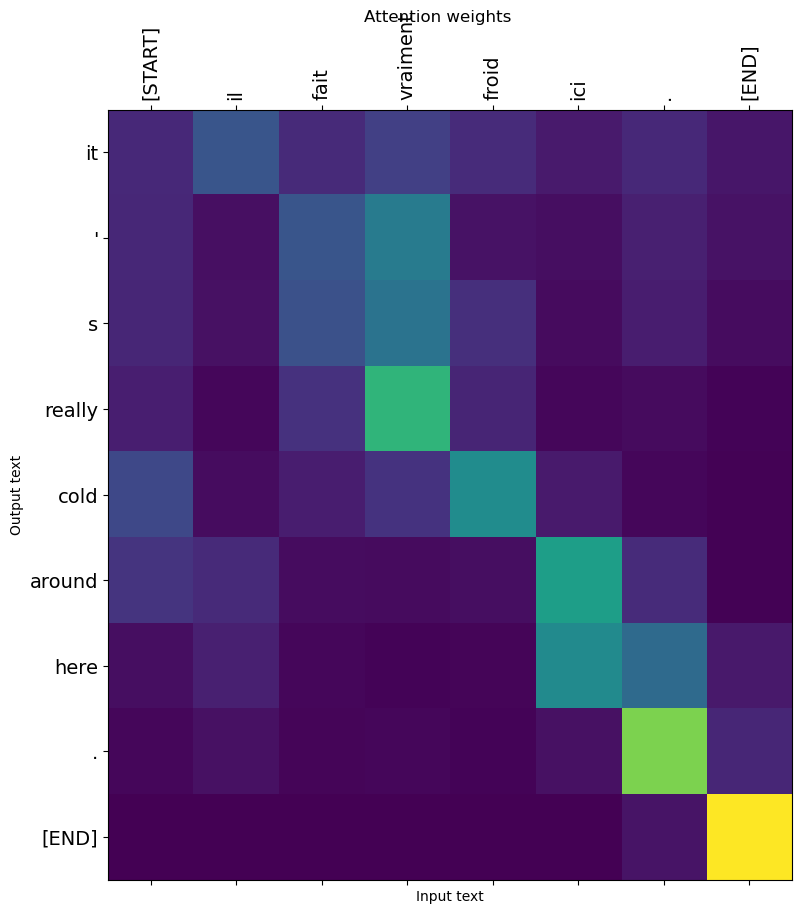

In [137]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

TRANSLATE SOME SUPPLEMENTARY SENTENCE AND DRAW IT

In [138]:
%%time
three_input_text = tf.constant([
    'C\'est ma vie.',
    'Sont-ils toujours a la maison?',
    'Essayer de trouver.'
])
result = translator.tf_translate(three_input_text)
for tr in result['text']:
    print(tr.numpy().decode())
print()

my life .
are these still at home ?
there ' s something trying to find .

CPU times: total: 3.06 s
Wall time: 2.56 s


In [139]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'my life .', b'are these still at home ?',
       b"there ' s something trying to find ."], dtype=object)>

C:\Users\RAKOTONDRAVAO\AppData\Local\Temp\ipykernel_10800\1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\RAKOTONDRAVAO\AppData\Local\Temp\ipykernel_10800\1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


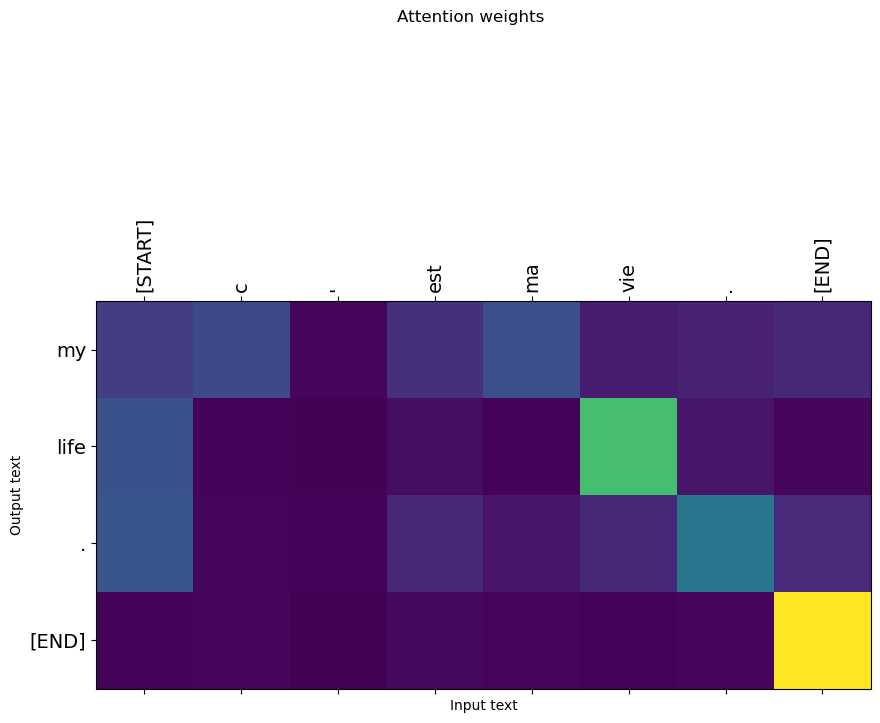

In [140]:
i=0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

TEST IT TO LONG SENTENCE

In [141]:
long_input_text = tf.constant([inp[-1]])
import textwrap
print('Output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Output:
 It may be impossible to get a completely error-free corpus due to the
nature of this kind of collaborative effort. However, if we encourage
members to contribute sentences in their own languages rather than
experiment in languages they are learning, we might be able to
minimize errors.


C:\Users\RAKOTONDRAVAO\AppData\Local\Temp\ipykernel_10800\1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\RAKOTONDRAVAO\AppData\Local\Temp\ipykernel_10800\1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


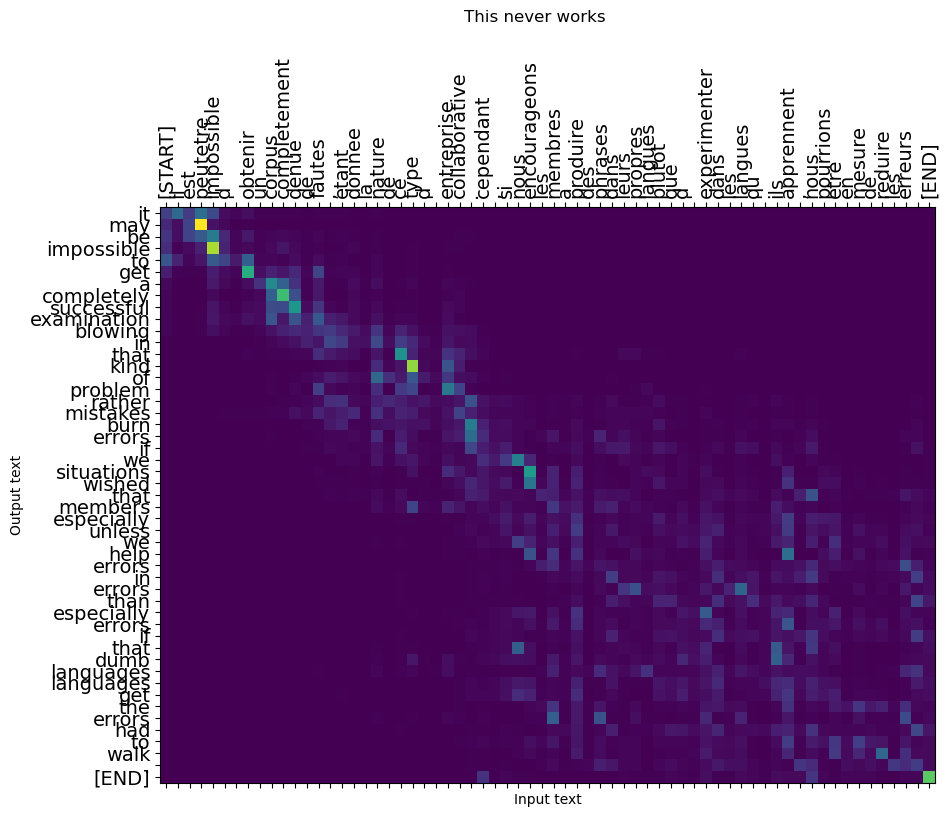

In [143]:
result = translator.tf_translate(long_input_text)
i=0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

### EXPORTATION

In [144]:
tf.saved_model.save(translator, 'translator', signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: translator\assets


INFO:tensorflow:Assets written to: translator\assets
